In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import importlib
import sys
sys.path.insert(0, "../src")

print(tf.__version__)

2.1.0


In [2]:
from euler import fwd, fwd_tlist, fwd_sde_tlist
importlib.reload(sys.modules['euler'])
import models as md
importlib.reload(sys.modules['models'])
import training as tr
importlib.reload(sys.modules['training'])
from utilities import rand_batch, tile_batch
importlib.reload(sys.modules['utilities'])

Using TensorFlow backend.


<module 'utilities' from '../src/utilities.py'>

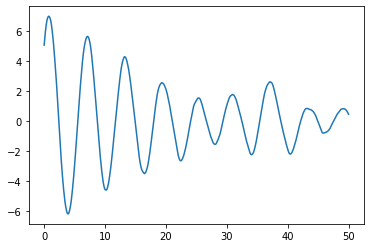

CPU times: user 1.34 s, sys: 6.5 ms, total: 1.35 s
Wall time: 1.35 s


In [22]:
%%time
t_end = 50
t_free = np.linspace(0, t_end, t_end/0.01)
y0_free = tf.constant([[5.], [5.]], tf.float32)

free_trajectory = fwd_sde_tlist(md.Oscillator(), y0_free, t_free,0.01)
plt.plot(t_free,free_trajectory[0:len(t_free),0,0])
plt.show()

In [17]:
len(t_free)

1000

# Van der Pol Oscillator

In [49]:
%%time
time_steps = 1000
t_free = np.linspace(0, 100, time_steps)
y0 = tf.constant([[1.0], [0.]], tf.float32)
model = md.VDPOscillator()

free_trajectory = fwd_tlist(model, y0, t_free, 1e-2)
free_trajectory = np.concatenate(free_trajectory[:,0,0])

# plt.plot(t_free,free_trajectory)
# plt.show()

CPU times: user 4.87 s, sys: 64.8 ms, total: 4.94 s
Wall time: 5.02 s


# Controlled Van der Pol Oscillator

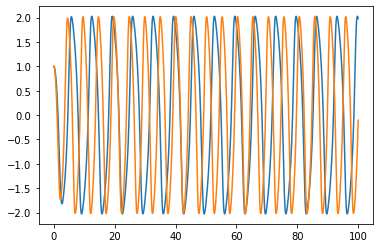

CPU times: user 18.2 s, sys: 306 ms, total: 18.5 s
Wall time: 19 s


In [51]:
%%time
time_steps = 1000
t_grid = np.linspace(0, 100, time_steps)
y0 = tf.constant([[1.0], [0.]], tf.float32)
model = md.VDPOscillatorNNControl()

trajectory = fwd_tlist(model, y0, t_grid, 1e-2)
trajectory = np.concatenate(trajectory[:,0,0])

plt.plot(t_free,free_trajectory, t_grid,trajectory)
plt.show()

# Train

In [57]:
def train_ode(model, batch_size, niters, test_freq, t_grid, free_trajectory):
    y0 = tf.cast([[[1.], [0.]]],tf.float32)

    optimizer = tf.keras.optimizers.Adamax(learning_rate=1e-2)
    
    loss_history = []

    for step in range(niters+1):
    
        # batch_y0 = rand_batch(batch_size) # Random
        batch_y0 = tile_batch(batch_size, y0) # Fixed

        loss = tr.gradient_update(model, fwd_tlist, optimizer, batch_y0, t_grid)
   
        loss_history.append(loss.numpy())

        if step % test_freq == 0:
            trajectory = fwd_tlist(model, y0, t_grid, 1e-2)
            print(loss)

            trajectory = np.concatenate(trajectory[:,0,0])
            plt.plot(t_grid,free_trajectory, t_grid,trajectory)
            plt.legend( ('free oscillator', 'controlled oscillator/system'))
            plt.show()

    return loss_history

In [58]:
def train_sde(model, batch_size, niters, test_freq, t_grid, free_trajectory):
    y0 = tf.cast([[[1.], [0.]]],tf.float32)

    optimizer = tf.keras.optimizers.Adamax(learning_rate=1e-2)
    
    loss_history = []

    for step in range(niters+1):
    
        # batch_y0 = rand_batch(batch_size) # Random
        batch_y0 = tile_batch(batch_size, y0) # Fixed

        loss = tr.gradient_update(model, fwd_sde_tlist, optimizer, batch_y0, t_grid)
   
        loss_history.append(loss.numpy())

        if step % test_freq == 0:
            trajectory = fwd_sde_tlist(model, y0, t_grid, 1e-2)        
            print(loss)

            trajectory = np.concatenate(trajectory[:,0,0])
            plt.plot(t_grid,free_trajectory, t_grid,trajectory)
            plt.legend( ('free oscillator', 'controlled oscillator/system'))
            plt.show()

    return loss_history

## ODE system

In [59]:
# Set up parameters
time_steps = 50
t_grid = np.linspace(0, 30, time_steps)

# Free system for comparison
free_trajectory = fwd_tlist(md.VDPOscillator(), y0, t_grid, 1e-2)
free_trajectory = np.concatenate(free_trajectory[:,0,0])

# Initialise new instance of the model
model = md.VDPOscillatorNNControl()

tf.Tensor([2.364893], shape=(1,), dtype=float32)


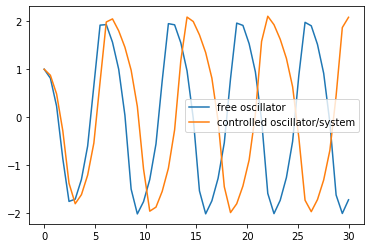

tf.Tensor([0.06862278], shape=(1,), dtype=float32)


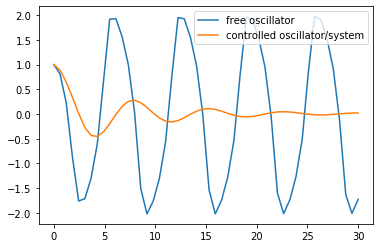

tf.Tensor([0.05443816], shape=(1,), dtype=float32)


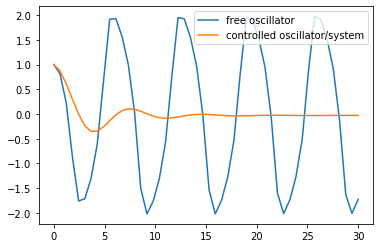

tf.Tensor([0.05081966], shape=(1,), dtype=float32)


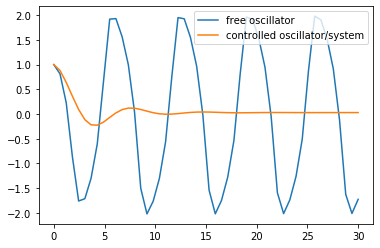

In [60]:
batch_size = 5
niters = 60
test_freq = 20

loss_history = train_ode(model, batch_size, niters, test_freq, t_grid, free_trajectory)

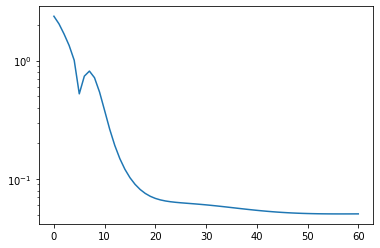

In [61]:
plt.plot(loss_history)
plt.yscale("log")

## SDE system

In [62]:
# Set up parameters
time_steps = 50
t_grid = np.linspace(0, 30, time_steps)

# Free system for comparison
free_trajectory = fwd_sde_tlist(md.VDPOscillator(), y0, t_grid, 1e-2)
free_trajectory = np.concatenate(free_trajectory[:,0,0])

# Initialise new instance of the model
sde_model = md.VDPOscillatorNNControl()

tf.Tensor([2.29559], shape=(1,), dtype=float32)


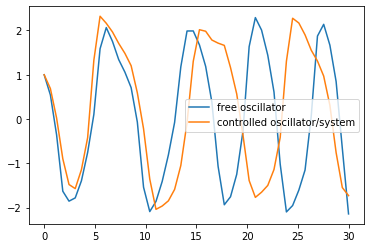

tf.Tensor([1.2787595], shape=(1,), dtype=float32)


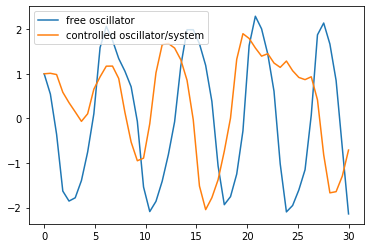

tf.Tensor([1.1992646], shape=(1,), dtype=float32)


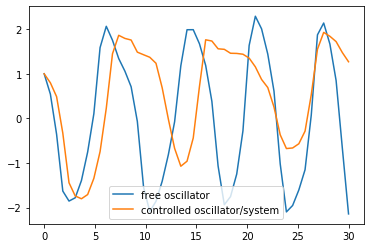

tf.Tensor([1.2793498], shape=(1,), dtype=float32)


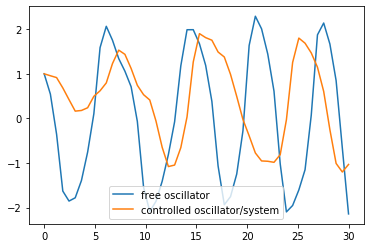

In [63]:
batch_size = 5
niters = 30
test_freq = 10

loss_history = train_sde(sde_model, batch_size, niters, test_freq, t_grid, free_trajectory)

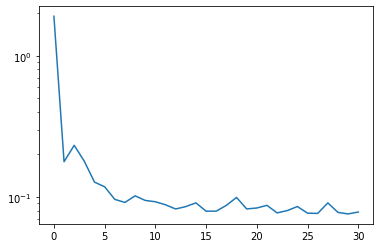

In [21]:
plt.plot(loss_history)
plt.yscale("log")